## Import data:

In [48]:
import requests     # 2.18.4
import pandas as pd # 0.23.0
import datetime
import io
import re
from timedisagg.td import TempDisagg
from datetime import date

When importing "TempDisagg", one needs to change the file "td.py" in the library to the following:
https://github.com/peterlravn/timedisagg/blob/master/timedisagg/td.py

Mine is at: "E:\Anaconda\Lib\site-packages\timedisagg"

In [49]:
def download_data(key_string_start, key_string_main, start_year, end_year):
    entrypoint = 'https://sdw-wsrest.ecb.europa.eu/service/' # Using protocol 'https'
    resource = 'data'           # The resource for data queries is always'data'
    flowRef = key_string_start              # Dataflow describing the data that needs to be returned, exchange rates in this case
    key = key_string_main    # Defining the dimension values, explained below

    # Define the parameters
    parameters = {
        'startPeriod': start_year,  # Start date of the time series
        'endPeriod': end_year     # End of the time series
    }

    request_url = entrypoint + resource + '/'+ flowRef + '/' + key
    
    name_response = requests.get(request_url, params=parameters)

    response = requests.get(request_url, params=parameters, headers={'Accept': 'text/csv'})
    
    name = re.findall('Value id="TITLE" value=.+?\"', name_response.text)[0][23::].replace('\"','')

    df = pd.read_csv(io.StringIO(response.text))

    ts = df.filter(['TIME_PERIOD', 'OBS_VALUE'], axis=1)

    ts = ts.set_index('TIME_PERIOD')
    
    full_key_string = key_string_start + "." + key_string_main
    
    ts.to_csv(f"{full_key_string}.csv")
    
    print(name)
    
    ts.plot()
    
    return ts

today = date.today().strftime("%Y-%m-%d")

start_date = "2000-01-01"

## Transform quarterly GDP into monthly GDP:

GDP = MNA.Q.Y.I8.W2.S1.S1.B.B1GQ._Z._Z._Z.IX.LR.N

Industrial Product = STS.M.I8.Y.PROD.NS0010.4.000

Assets = ILM.W.U2.C.T000000.Z5.Z01

CISS = CISS.D.U2.Z0Z.4F.EC.SS_CI.IDX

MRO = FM.D.U2.EUR.4F.KR.MRR_RT.LEV

EONIA = EON.D.EONIA_TO.RATE

HICP = ICP.M.U2.Y.000000.3.INX

DEPOSIT = FM.D.U2.EUR.4F.KR.DFR.CHG

Gross domestic product at market prices
Industrial production; total including construction 


<AxesSubplot:xlabel='TIME_PERIOD'>

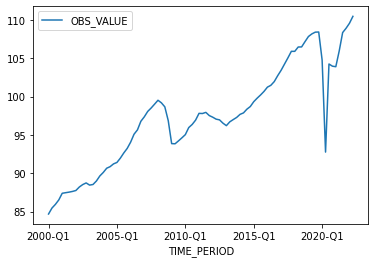

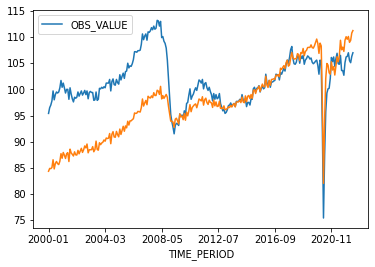

In [50]:
GDP = download_data("MNA", "Q.Y.I8.W2.S1.S1.B.B1GQ._Z._Z._Z.IX.LR.N", start_date, "2022-07-01") #Quarterly

INDUSTRIAL_PROD = download_data("STS", "M.I8.Y.PROD.NS0010.4.000", start_date, "2022-07-01") #Monthly

GDP_extended = pd.concat([GDP, GDP, GDP])

GDP_extended = GDP_extended.sort_index()

GDP_extended = GDP_extended["OBS_VALUE"].values.tolist()

INDUSTRIAL_PROD["GDP"] = GDP_extended[0:len(INDUSTRIAL_PROD)]

INDUSTRIAL_PROD = INDUSTRIAL_PROD.reset_index()

INDUSTRIAL_PROD[['index', 'grain']] = INDUSTRIAL_PROD['TIME_PERIOD'].str.split('-', expand=True)

INDUSTRIAL_PROD = INDUSTRIAL_PROD.drop("TIME_PERIOD", axis=1)

INDUSTRIAL_PROD = INDUSTRIAL_PROD.rename(columns={"OBS_VALUE": "X", "GDP": "y"})

cols = INDUSTRIAL_PROD.columns.tolist()

cols = cols[-2:] + cols[:-2]

INDUSTRIAL_PROD = INDUSTRIAL_PROD[cols]

INDUSTRIAL_PROD = INDUSTRIAL_PROD.astype(float)

td_obj = TempDisagg(conversion="average", method="chow-lin-minrss-ecotrim")
GDP_df = td_obj(INDUSTRIAL_PROD[0:len(INDUSTRIAL_PROD)-len(INDUSTRIAL_PROD)%3])

GDP_df["y_hat"].plot()

In [51]:
GDP_df

,index,grain,X,y,y_hat
0,2000.0,1.0,95.4,84.685688,84.341994
1,2000.0,2.0,96.5,84.685688,84.880440
2,2000.0,3.0,97.0,84.685688,84.834631
3,2000.0,4.0,97.8,85.461327,85.059831
4,2000.0,5.0,99.7,85.461327,86.538558
...,...,...,...,...,...
265,2022.0,2.0,107.0,109.561351,110.112605
266,2022.0,3.0,105.5,109.561351,108.990357
267,2022.0,4.0,105.1,110.461316,109.364002
268,2022.0,5.0,106.3,110.461316,110.780759


## Assets weekly to monthly

Total assets/liabilities - Eurosystem


<AxesSubplot:xlabel='WEEKS'>

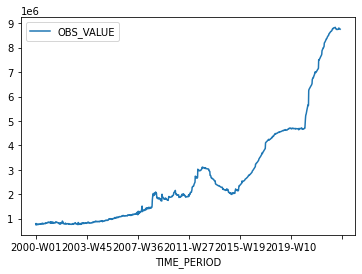

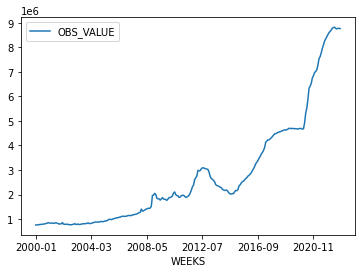

In [52]:
ASSETS = download_data("ILM", "W.U2.C.T000000.Z5.Z01", start_date, today) #Weekly

time_list = []
first_date = date.fromisoformat('2000-01-01')-datetime.timedelta(days=4)

for i in range(len(ASSETS)):
    first_date += datetime.timedelta(days=7)
    time_list.append((first_date).strftime("%Y-%m"))
    
ASSETS["WEEKS"] = time_list

ASSETS = ASSETS.groupby(by="WEEKS").mean()

ASSETS.plot()

## CISS weekly to monthly

CISS - Composite Indicator of Systemic Stress


<AxesSubplot:xlabel='WEEKS'>

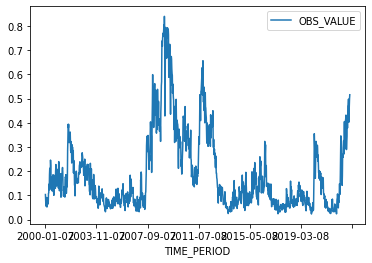

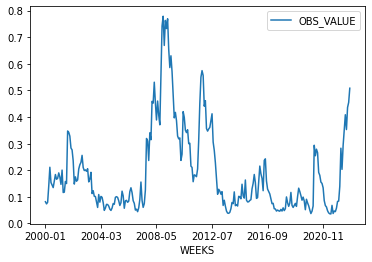

In [53]:
CISS = download_data("CISS", "D.U2.Z0Z.4F.EC.SS_CI.IDX", start_date, today) #Weekly

time_list = []
first_date = date.fromisoformat('2000-01-01')-datetime.timedelta(days=4)

for i in range(len(CISS)):
    first_date += datetime.timedelta(days=7)
    time_list.append((first_date).strftime("%Y-%m"))
    
CISS["WEEKS"] = time_list

CISS = CISS.groupby(by="WEEKS").mean()

CISS.plot()

## MRO daily to monthly

ECB Main refinancing operations - Minimum bid rate/fixed rate (date of changes) - Level
ECB Deposit facility - date of changes (raw data) - Level
ECB Marginal lending facility - date of changes (raw data) - Level
Rate for the overnight maturity calculated as the euro short-term rate plus a spread of 8.5 basis points


<AxesSubplot:xlabel='WEEKS'>

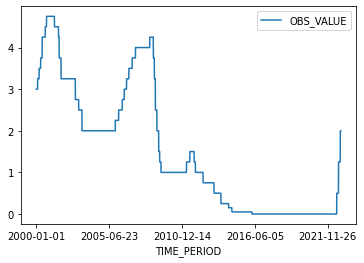

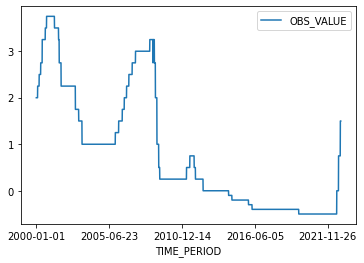

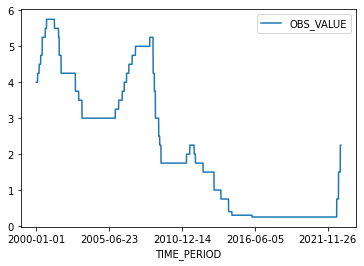

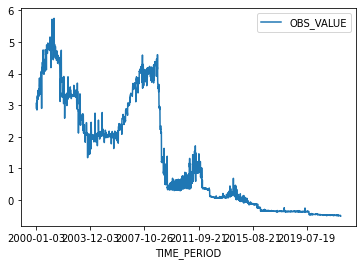

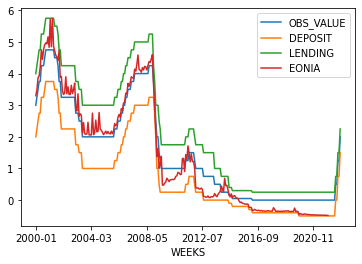

In [54]:
MRO = download_data("FM", "D.U2.EUR.4F.KR.MRR_RT.LEV", start_date, today) #DAILY
DEPOSIT = download_data("FM", "D.U2.EUR.4F.KR.DFR.LEV", start_date, today) #DAILY
LENDING = download_data("FM", "D.U2.EUR.4F.KR.MLFR.LEV", start_date, today) #DAILY
EONIA = download_data("EON", "D.EONIA_TO.RATE", start_date, today) #Daily

NEW_MRO = MRO
NEW_MRO["DEPOSIT"] = DEPOSIT
NEW_MRO["LENDING"] = LENDING
NEW_MRO["EONIA"] = EONIA

NEW_MRO.to_stata(r"C:\Users\Peter\OneDrive\My Own Projects\Bachelor\Test folder\MRO_DATA.dta")

MRO["WEEKS"] = MRO.index.str[:7]
DEPOSIT["WEEKS"] = DEPOSIT.index.str[:7]
LENDING["WEEKS"] = LENDING.index.str[:7]

MRO = MRO.groupby(by="WEEKS").max()
DEPOSIT = DEPOSIT.groupby(by="WEEKS").max()
LENDING = LENDING.groupby(by="WEEKS").max()

MRO.plot()

In [55]:
NEW_MRO

,OBS_VALUE,DEPOSIT,LENDING,EONIA,WEEKS
TIME_PERIOD,,,,,
2000-01-01,3.0,2.0,4.00,NaN,2000-01
2000-01-02,3.0,2.0,4.00,NaN,2000-01
2000-01-03,3.0,2.0,4.00,3.06,2000-01
2000-01-04,3.0,2.0,4.00,3.01,2000-01
2000-01-05,3.0,2.0,4.00,2.99,2000-01
...,...,...,...,...,...
2022-11-10,2.0,1.5,2.25,NaN,2022-11
2022-11-11,2.0,1.5,2.25,NaN,2022-11
2022-11-12,2.0,1.5,2.25,NaN,2022-11


## EONIA daily to monthly

Rate for the overnight maturity calculated as the euro short-term rate plus a spread of 8.5 basis points


<AxesSubplot:xlabel='WEEKS'>

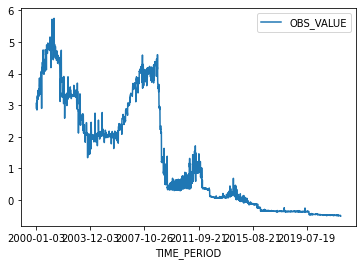

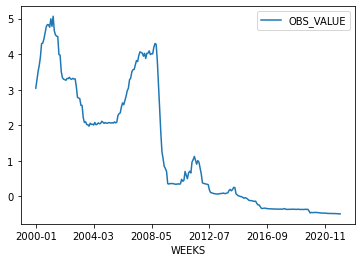

In [56]:
EONIA = download_data("EON", "D.EONIA_TO.RATE", start_date, today) #Daily

EONIA["WEEKS"] = EONIA.index.str[:7]

EONIA = EONIA.groupby(by="WEEKS").mean()

EONIA.plot()

## HICP non transformed

HICP - Overall index


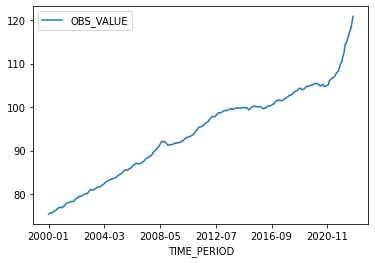

In [57]:
HICP = download_data("ICP", "M.U2.Y.000000.3.INX", start_date, today) #Monthly

## ESTR daily to monthly

Euro short-term rate - Volume-weighted trimmed mean rate


<AxesSubplot:xlabel='WEEKS'>

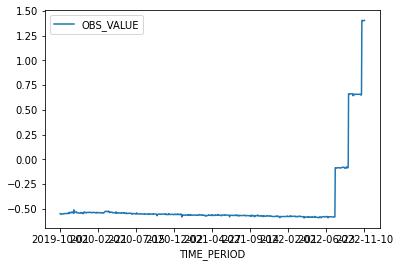

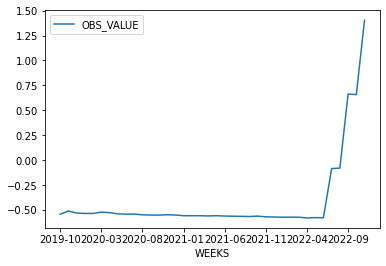

In [58]:
ESTR = download_data("EST", "B.EU000A2X2A25.WT", start_date, today) 

ESTR["WEEKS"] = ESTR.index.str[:7]

ESTR = ESTR.groupby(by="WEEKS").max()

ESTR.plot()

## Collect all

In [59]:
GDP_df

,index,grain,X,y,y_hat
0,2000.0,1.0,95.4,84.685688,84.341994
1,2000.0,2.0,96.5,84.685688,84.880440
2,2000.0,3.0,97.0,84.685688,84.834631
3,2000.0,4.0,97.8,85.461327,85.059831
4,2000.0,5.0,99.7,85.461327,86.538558
...,...,...,...,...,...
265,2022.0,2.0,107.0,109.561351,110.112605
266,2022.0,3.0,105.5,109.561351,108.990357
267,2022.0,4.0,105.1,110.461316,109.364002
268,2022.0,5.0,106.3,110.461316,110.780759


In [60]:
ASSETS = ASSETS.rename(columns={"OBS_VALUE": "ASSETS"})

ASSETS["CISS"] = CISS
ASSETS["MRO"] = DEPOSIT
ASSETS["EONIA"] = EONIA
ASSETS["HICP"] = HICP
ASSETS["ESTR"] = ESTR
ASSETS = ASSETS.reset_index()
ASSETS["INDEX"] = GDP_df["index"]
ASSETS["grain"] = GDP_df["grain"]
ASSETS["X"] = GDP_df["X"]
ASSETS["y"] = GDP_df["y"]
ASSETS["y_hat"] = GDP_df["y_hat"]

In [61]:
DEPOSIT

,OBS_VALUE
WEEKS,
2000-01,2.00
2000-02,2.25
2000-03,2.50
2000-04,2.75
2000-05,2.75
...,...
2022-07,0.00
2022-08,0.00
2022-09,0.75


In [62]:
ASSETS.to_stata(r"C:\Users\Peter\OneDrive\My Own Projects\Bachelor\collected_dataset_ny.dta")

In [63]:
ASSETS

,WEEKS,ASSETS,CISS,MRO,EONIA,HICP,ESTR,INDEX,grain,X,y,y_hat
0,2000-01,7.615937e+05,0.081752,2.00,3.042857,75.44890,NaN,2000.0,1.0,95.4,84.685688,84.341994
1,2000-02,7.615222e+05,0.073568,2.25,3.275714,75.57891,NaN,2000.0,2.0,96.5,84.685688,84.880440
2,2000-03,7.631938e+05,0.079770,2.50,3.510435,75.74366,NaN,2000.0,3.0,97.0,84.685688,84.834631
3,2000-04,7.740491e+05,0.141133,2.75,3.685000,75.73017,NaN,2000.0,4.0,97.8,85.461327,85.059831
4,2000-05,7.769146e+05,0.211350,2.75,3.920000,75.83937,NaN,2000.0,5.0,99.7,85.461327,86.538558
...,...,...,...,...,...,...,...,...,...,...,...,...
270,2022-07,8.768216e+06,0.408765,0.00,NaN,117.24356,-0.085,NaN,NaN,NaN,NaN,NaN
271,2022-08,8.750264e+06,0.352997,0.00,NaN,117.91500,-0.080,NaN,NaN,NaN,NaN,NaN
272,2022-09,8.775870e+06,0.436088,0.75,NaN,119.14718,0.663,NaN,NaN,NaN,NaN,NaN
273,2022-10,8.773869e+06,0.454992,0.75,NaN,120.86837,0.658,NaN,NaN,NaN,NaN,NaN
